In [22]:
from pathlib import Path

from dataset import ImageDataset, get_image_paths_df

img_paths_df = get_image_paths_df(Path("data_col_public/"))
dataset = ImageDataset(img_paths_df)

In [23]:
len(dataset)

4700

In [24]:
img_paths_df[0]

img_gray_path,img_rgb_path
str,str
"""data_col_public/img_gray/hambu…","""data_col_public/img_rgb/hambur…"


In [25]:
dataset[0]

(tensor([[[0.1882, 0.1961, 0.2000,  ..., 0.9098, 0.9922, 0.8706],
          [0.2549, 0.2471, 0.2471,  ..., 0.9176, 0.9882, 0.8784],
          [0.3176, 0.3059, 0.2902,  ..., 0.9216, 0.9843, 0.8824],
          ...,
          [0.4980, 0.4902, 0.4902,  ..., 0.4510, 0.4471, 0.4471],
          [0.4980, 0.4902, 0.4902,  ..., 0.4471, 0.4431, 0.4392],
          [0.4980, 0.4902, 0.4902,  ..., 0.2941, 0.2902, 0.4078]]]),
 tensor([[[0.2118, 0.2157, 0.2196,  ..., 0.7529, 0.9020, 0.6824],
          [0.2784, 0.2667, 0.2588,  ..., 0.7490, 0.8863, 0.6902],
          [0.3373, 0.3255, 0.3098,  ..., 0.7569, 0.8824, 0.6902],
          ...,
          [0.5098, 0.5020, 0.5020,  ..., 0.4706, 0.4667, 0.4667],
          [0.5098, 0.5020, 0.5020,  ..., 0.4627, 0.4588, 0.4549],
          [0.5098, 0.5020, 0.5020,  ..., 0.3059, 0.3020, 0.4235]],
 
         [[0.1412, 0.1451, 0.1490,  ..., 0.6824, 0.8039, 0.6902],
          [0.2392, 0.2235, 0.2118,  ..., 0.6863, 0.7725, 0.6824],
          [0.2235, 0.2157, 0.2039,  ...,

In [26]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(600, 420),
        A.RandomCrop(512, 384),  # 4x3
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.2),
        A.Normalize(normalization="min_max"),
        ToTensorV2(),
    ],
    additional_targets={"rgb_image": "image"},
)

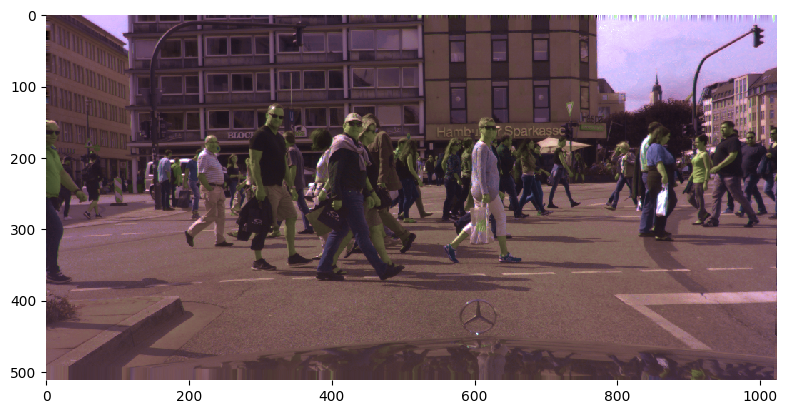

In [27]:
import matplotlib.pyplot as plt


def ishow(
    img, cmap="viridis", title="", fig_size=(8, 6), colorbar=False, interpolation="none"
):
    "Function `ishow` displays an image in a new window."

    # extent = (0, img.shape[1], img.shape[0], 0)
    img = img.permute(1, 2, 0).cpu().detach().numpy()
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(
        img,
        # extent=extent,
        cmap=cmap,
        interpolation=interpolation,
    )

    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation="vertical")
    plt.show()


ishow(dataset[0][1])

In [28]:
def show_augmentations(ds, idx, n_samples=3):
    figure = plt.figure(figsize=(12, 8))

    rows = n_samples
    cols = 2

    for i in range(1, rows + 1):
        gray, rgb = ds[idx]

        gray_np = gray.permute(1, 2, 0).cpu().detach().numpy()
        rgb_np = rgb.permute(1, 2, 0).cpu().detach().numpy()

        if gray_np.min() < 0 or gray_np.max() > 1:
            print(
                f"The image values were shifted to the range (0, 1). The original range is ({gray_np.min():.04f}, {gray_np.max():.04f})"
            )
            gray_np = (gray_np - gray_np.min()) / (gray_np.max() - gray_np.min())
            rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min())

        figure.add_subplot(rows, cols, i * 2 - 1)
        plt.axis("off")
        plt.imshow(
            gray_np, cmap="gray"
        )  # if you don't use cmap="gray", matplotlib will use viridis

        figure.add_subplot(rows, cols, i * 2)
        plt.axis("off")
        plt.imshow(rgb_np)

    plt.suptitle(f"Sample No {idx}")
    plt.tight_layout()
    plt.show()


In [29]:
dataset = ImageDataset(img_paths_df, train_transform)

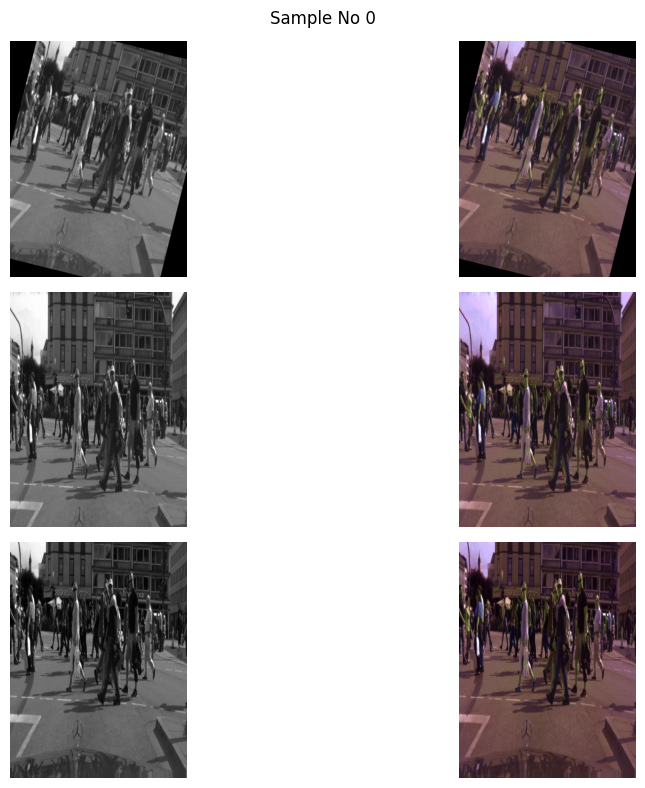

In [30]:
show_augmentations(dataset, 0)

In [ ]:
import torch
from torch.utils.data import DataLoader

from dataset import WrappedDataLoader, split_dataset

batch_size = 8

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_dataset, val_dataset, _ = split_dataset(img_paths_df, 0.15, 0.1)

train_dataloader = WrappedDataLoader(
    DataLoader(train_dataset, batch_size=batch_size), device
)
val_dataloader = WrappedDataLoader(
    DataLoader(val_dataset, batch_size=batch_size, shuffle=True), device
)


In [32]:
for inputs, targets in train_dataloader:
    print(inputs.shape)
    print(targets.shape)
    break

torch.Size([8, 1, 512, 384])
torch.Size([8, 3, 512, 384])


In [33]:
from network import Discriminator, Generator

G, D = Generator().to(device), Discriminator().to(device)

In [34]:
from network import discriminator_loss, generator_loss

generator_output = G(inputs)
discriminator_real_output = D(inputs.repeat(1, 3, 1, 1), targets)
discriminator_generated_output = D(inputs.repeat(1, 3, 1, 1), generator_output)

total_G_loss, G_loss, G_l1_loss = generator_loss(
    discriminator_generated_output, generator_output, targets
)
D_loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)


D_loss.backward()

In [ ]:
from dataclasses import dataclass
from pathlib import Path

import torch
from torch import Tensor
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import WrappedDataLoader, get_image_paths_df, split_dataset
from network import Discriminator, Generator, discriminator_loss, generator_loss


@dataclass
class config:
    lr: float = 0.0002
    momentum_betas: tuple[float, float] = (0.5, 0.999)


def generate_image(
    model: Generator, input: Tensor, target: Tensor, plot_subtitle: str = ""
):
    # input has a shape C x H x W
    # target has a shape C x H x W
    predicted = model(input.unsqueeze(0))  # add a batch dimension
    plt.figure(figsize=(15, 15))

    input_np = input.permute(1, 2, 0).cpu().detach().numpy()
    target_np = target.permute(1, 2, 0).cpu().detach().numpy()
    predicted_np = predicted.squeeze().permute(1, 2, 0).cpu().detach().numpy()

    display_list = [input_np, target_np, predicted_np]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)

        plt.title(title[i])
        if title[i] == "Input Image":
            plt.imshow(display_list[i] * 0.5 + 0.5, cmap="gray")
        else:
            plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.suptitle(plot_subtitle)


def fit(
    G: Generator,
    D: Discriminator,
    epochs: int,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    optimizer_G: Optimizer,
    optimizer_D: Optimizer,
    input_to_vizu: Tensor,
    target_to_vizu: Tensor,
    device: torch.device,
) -> tuple[list[float], list[float]]:
    G_train_losses: list[float] = []
    L1_train_losses: list[float] = []
    D_train_losses: list[float] = []

    G_val_losses: list[float] = []
    L1_val_losses: list[float] = []
    D_val_losses: list[float] = []

    for epoch in range(epochs):
        G.train()
        D.train()

        for inputs, targets in tqdm(train_dataloader):
            step_result = fit_step(G, D, optimizer_G, optimizer_D, inputs, targets)

            # graph variables
            G_train_losses.append(step_result.total_G_loss.cpu())
            D_train_losses.append(step_result.D_loss.cpu())
            L1_train_losses.append(step_result.G_l1_loss.cpu())

        G.eval()
        D.eval()
        with torch.no_grad():
            for inputs, targets in tqdm(val_dataloader):
                step_result = fit_step(
                    G, D, None, None, inputs, targets
                )  # optimizers are none -> don't update

                # graph variables
                G_val_losses.append(step_result.total_G_loss)
                D_val_losses.append(step_result.D_loss)
                L1_val_losses.append(step_result.G_l1_loss)

        # print training

        print(
            f"Epoch: {epoch}, train_G_loss: {G_train_losses[-1]:.3f} | train_L1_loss: {L1_train_losses[-1]:.3f} | train_D_loss: {D_train_losses[-1]:.3f}"
        )

        print(
            f"Epoch: {epoch}, val_G_loss: {G_val_losses[-1]:.3f} | val_L1_loss: {L1_val_losses[-1]:.3f} | val_D_loss: {D_val_losses[-1]:.3f}"
        )
        print(inputs[-1].shape)
        generate_image(G, input_to_vizu, target_to_vizu, f"epoch: {epoch}")
    print("Training finished!")
    return G_train_losses, D_train_losses


@dataclass
class FitStepResult:
    total_G_loss: float
    G_loss: float
    G_l1_loss: float
    D_loss: float


bce = torch.nn.BCELoss()
l1 = torch.nn.L1Loss()


def fit_step(
    G: Generator,
    D: Discriminator,
    optimizer_G: Optimizer | None,
    optimizer_D: Optimizer | None,
    inputs: Tensor,
    targets: Tensor,
):
    generator_output = G(inputs)

    inputs = inputs.repeat(1, 3, 1, 1)

    discriminator_real_output = D(inputs, targets)
    discriminator_generated_output = D(inputs, generator_output)

    total_G_loss, G_loss, G_l1_loss = generator_loss(
        discriminator_generated_output, generator_output, targets
    )
    D_loss = discriminator_loss(
        discriminator_real_output, discriminator_generated_output
    )

    if optimizer_G is not None:
        optimizer_G.zero_grad()
        total_G_loss.backward()
        optimizer_G.step()

    if optimizer_D is not None:
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

    return FitStepResult(total_G_loss, G_loss, G_l1_loss, D_loss)


def training(dataset_path: Path) -> None:
    """Performs training on the given dataset.

    Args:
        dataset_path: Path to the dataset.

    Saves:
        - model.pt (trained model)
        - learning_curves.png (learning curves generated during training)
        - model_architecture.png (a scheme of model's architecture)
    """
    # Check for available GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Computing with {}!".format(device))

    batch_size = 64

    img_paths_df = get_image_paths_df(dataset_path, n=300)

    train_dataset, val_dataset, _ = split_dataset(img_paths_df, 0.15, 0.1)

    train_dataloader = WrappedDataLoader(
        DataLoader(train_dataset, batch_size=batch_size), device
    )
    val_dataloader = WrappedDataLoader(
        DataLoader(val_dataset, batch_size=batch_size, shuffle=True), device
    )

    D = Discriminator().to(device)
    G = Generator().to(device)

    # define optimizer and learning rate
    optimizer_G = Adam(G.parameters(), lr=config.lr, betas=config.momentum_betas)
    optimizer_D = Adam(D.parameters(), lr=config.lr, betas=config.momentum_betas)
    # define loss function

    # train the network
    train_losses, val_losses = fit(
        G,
        D,
        3,
        train_dataloader,
        val_dataloader,
        optimizer_G,
        optimizer_D,
        val_dataset[0][0].to(device),
        val_dataset[0][1].to(device),
        device,
    )

Computing with cuda!


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


Epoch: 0, train_G_loss: 110.497 | train_L1_loss: 0.602 | train_D_loss: 100.230
Epoch: 0, val_G_loss: 84.641 | val_L1_loss: 0.324 | val_D_loss: 100.002
torch.Size([1, 512, 1024])


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Epoch: 1, train_G_loss: 110.326 | train_L1_loss: 0.600 | train_D_loss: 100.262
Epoch: 1, val_G_loss: 84.776 | val_L1_loss: 0.316 | val_D_loss: 100.157
torch.Size([1, 512, 1024])


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch: 2, train_G_loss: 110.235 | train_L1_loss: 0.599 | train_D_loss: 100.239
Epoch: 2, val_G_loss: 84.815 | val_L1_loss: 0.317 | val_D_loss: 100.533
torch.Size([1, 512, 1024])
Training finished!


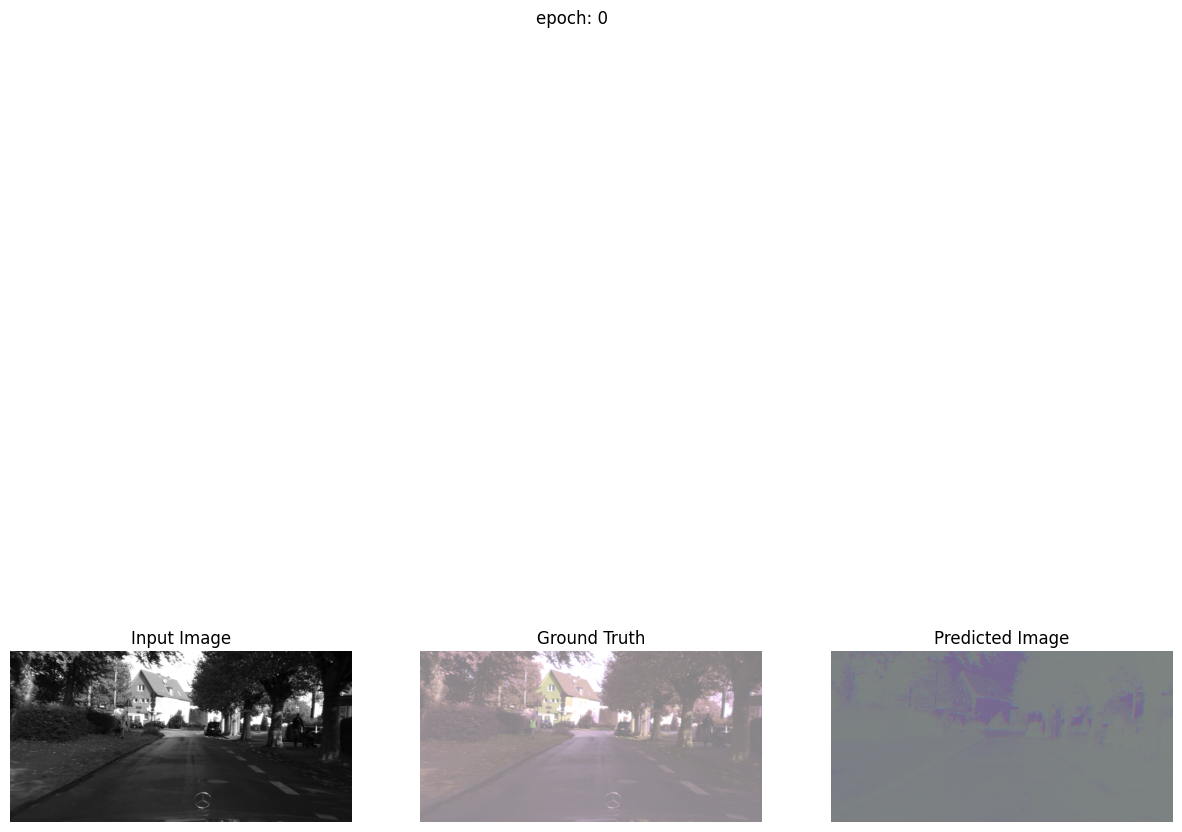

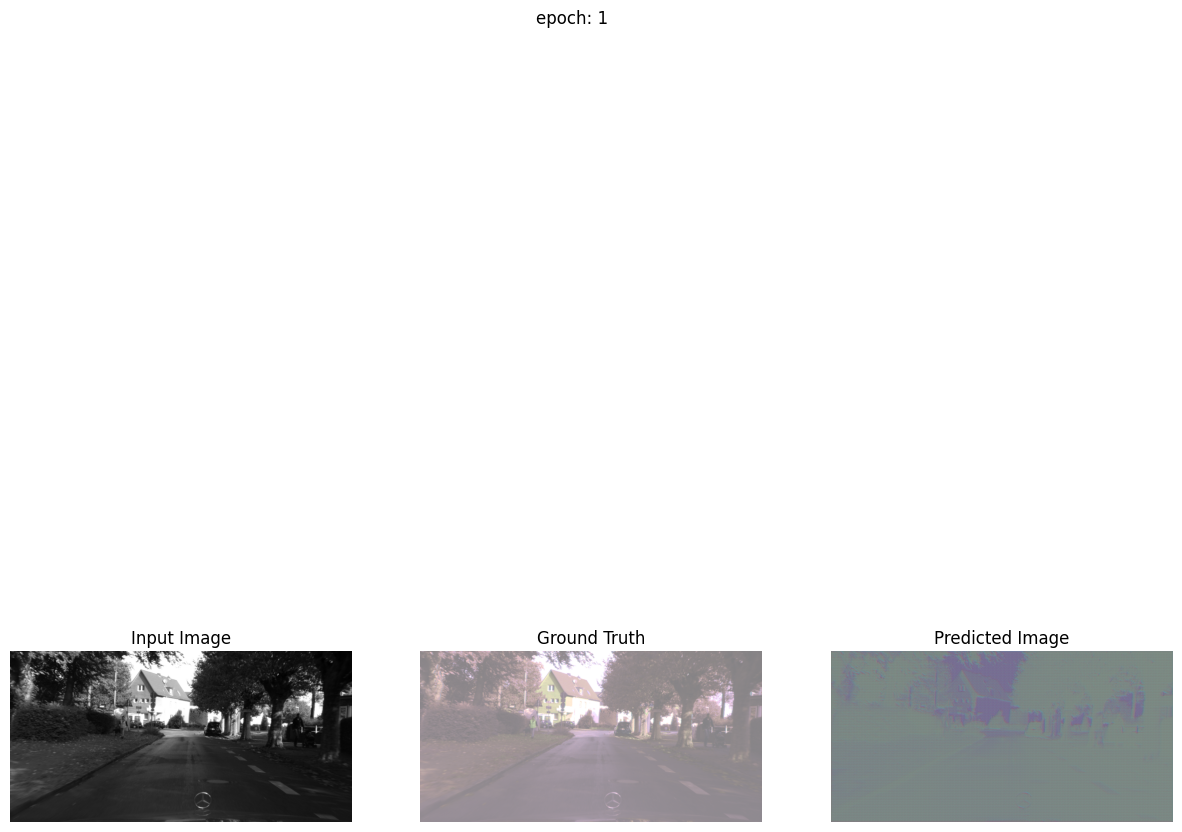

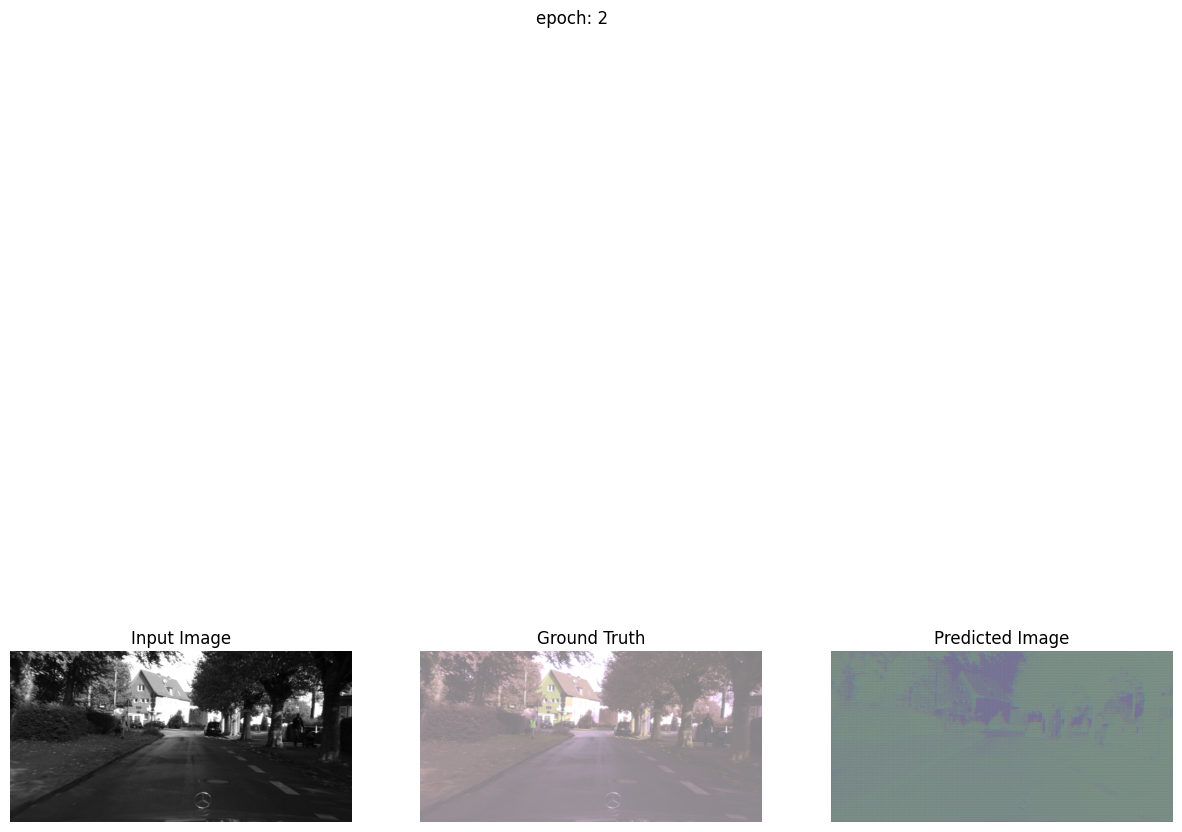

In [40]:
training(Path("data_col_public/"))

In [ ]:
dataset = ImageDataset(Path("data_col_public/"), train_transform)

In [29]:
dataset[0][0].max()

tensor(1.)

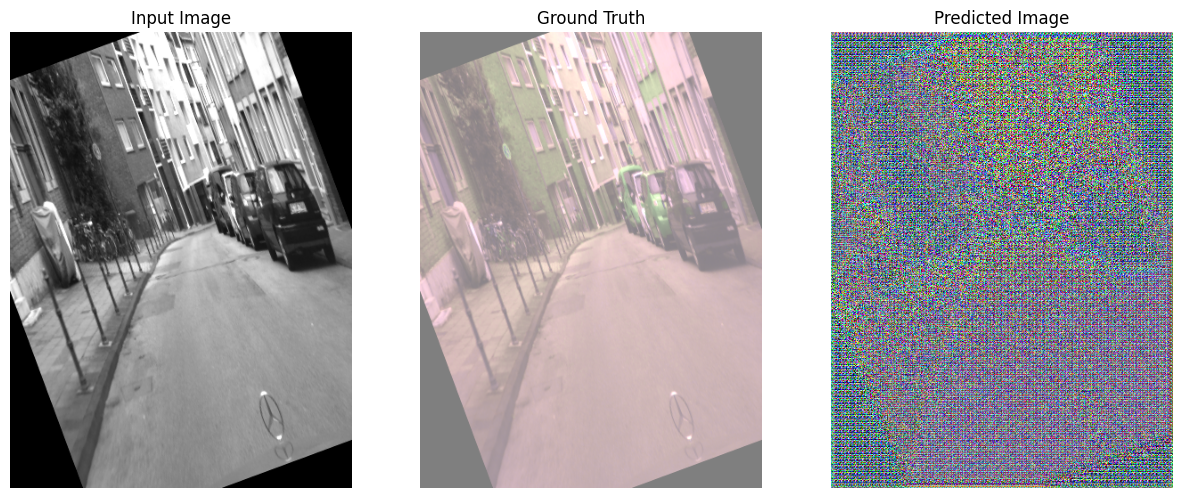

In [23]:
predicted.shape

torch.Size([1, 3, 512, 384])

In [2]:
from pathlib import Path

from dataset import ImageDataset, get_image_paths_df

img_paths_df = get_image_paths_df(Path("data_col_public"))

In [3]:
ImageDataset(img_paths_df)[0]

(tensor([[[0.1882, 0.1961, 0.2000,  ..., 0.9098, 0.9922, 0.8706],
          [0.2549, 0.2471, 0.2471,  ..., 0.9176, 0.9882, 0.8784],
          [0.3176, 0.3059, 0.2902,  ..., 0.9216, 0.9843, 0.8824],
          ...,
          [0.4980, 0.4902, 0.4902,  ..., 0.4510, 0.4471, 0.4471],
          [0.4980, 0.4902, 0.4902,  ..., 0.4471, 0.4431, 0.4392],
          [0.4980, 0.4902, 0.4902,  ..., 0.2941, 0.2902, 0.4078]]]),
 tensor([[[0.2118, 0.2157, 0.2196,  ..., 0.7529, 0.9020, 0.6824],
          [0.2784, 0.2667, 0.2588,  ..., 0.7490, 0.8863, 0.6902],
          [0.3373, 0.3255, 0.3098,  ..., 0.7569, 0.8824, 0.6902],
          ...,
          [0.5098, 0.5020, 0.5020,  ..., 0.4706, 0.4667, 0.4667],
          [0.5098, 0.5020, 0.5020,  ..., 0.4627, 0.4588, 0.4549],
          [0.5098, 0.5020, 0.5020,  ..., 0.3059, 0.3020, 0.4235]],
 
         [[0.1412, 0.1451, 0.1490,  ..., 0.6824, 0.8039, 0.6902],
          [0.2392, 0.2235, 0.2118,  ..., 0.6863, 0.7725, 0.6824],
          [0.2235, 0.2157, 0.2039,  ...,

In [4]:
len(img_paths_df)

4700

In [5]:
img_paths_df[0]["img_gray_path"].item()

'data_col_public/img_gray/hamburg/hamburg_000000_053486_leftImg8bit.png'

In [6]:
train_dataset, val_dataset, test_dataset = split_dataset(img_paths_df, 0.15, 0.1)

In [7]:
train_dataset[5]

(tensor([[[0.4575, 0.4691, 0.4679,  ..., 0.1127, 0.1332, 0.1423],
          [0.4564, 0.4664, 0.4674,  ..., 0.1101, 0.1225, 0.1460],
          [0.4553, 0.4675, 0.4671,  ..., 0.1091, 0.1189, 0.1525],
          ...,
          [0.1441, 0.1529, 0.1567,  ..., 0.2347, 0.2492, 0.2330],
          [0.1476, 0.1562, 0.1462,  ..., 0.2333, 0.2384, 0.2330],
          [0.1452, 0.1477, 0.1423,  ..., 0.2343, 0.2357, 0.2248]]]),
 tensor([[[0.4979, 0.5111, 0.5068,  ..., 0.1451, 0.1753, 0.1841],
          [0.4968, 0.5065, 0.5082,  ..., 0.1471, 0.1649, 0.1878],
          [0.4957, 0.5058, 0.5082,  ..., 0.1487, 0.1599, 0.1941],
          ...,
          [0.1818, 0.1903, 0.1941,  ..., 0.2662, 0.2775, 0.2727],
          [0.1852, 0.1936, 0.1816,  ..., 0.2739, 0.2799, 0.2727],
          [0.1829, 0.1853, 0.1793,  ..., 0.2763, 0.2750, 0.2604]],
 
         [[0.3202, 0.3279, 0.3281,  ..., 0.0727, 0.0882, 0.0952],
          [0.3191, 0.3265, 0.3277,  ..., 0.0710, 0.0819, 0.0962],
          [0.3180, 0.3278, 0.3279,  ...,

In [8]:
len(train_dataset)

3595

In [9]:
len(test_dataset)

705

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device.type

'cuda'